In [27]:
%matplotlib inline 
import pickle
import os
import numpy as np
import json
from PIL import Image,ImageDraw
import sys

import cv2
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import find_contours

from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box

In [2]:
from random import sample

In [3]:
imagePath = r'C:\Users\jiali\Desktop\choroColorRead\generatedMaps\quantiles'
imageName = 'us_Blues_4_pos_large.jpg'
# testImages = os.listdir(imagePath)

In [4]:
# read detection results from pickle file
detectResultsPath = r'D:\OneDrive - The Ohio State University\choroColorRead'
detectResultFileName = 'detectResultSpatialPattern.pickle'
with open(detectResultsPath + '\\' + detectResultFileName, 'rb') as f:
    detectResults = pickle.load(f)

In [5]:
detectResult = detectResults[-1]

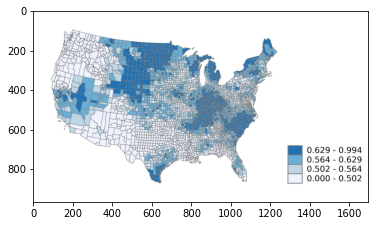

In [6]:
property = detectResult[1]
boxes = property['rois']
masks = property['masks']
class_ids = property['class_ids']

# extract mask for mapping area
N = boxes.shape[0]
if not N:
    print("\n*** No instances to display *** \n")
else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

image = cv2.imread(imagePath + '\\' + imageName)
imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

masked_image = image.astype(np.uint32).copy()
maskPolyList = []
#Show the image with matplotlib
plt.imshow(imageRGB)
plt.show()

In [7]:
image.shape

(966, 1695, 3)

In [8]:
height = image.shape[0]
print(height)
width = image.shape[1]
print(width)

966
1695


In [9]:
# get the polygon for mapping area
for i in range(N):
#     if i > 0:
#         continue
    if class_ids[i] != 3:
        continue
    # Bounding box
    if not np.any(boxes[i]):
        # Skip this instance. Has no bbox. Likely lost in image cropping.
        continue
    y1, x1, y2, x2 = boxes[i]
    bboxMap = box(x1, y1, x2, y2)
    # Mask
    mask = masks[:, :, i]

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        vertList = [(vert[0],vert[1]) for vert in verts]
        maskPolygon = Polygon(vertList)
        maskPolyList.append(maskPolygon)

In [10]:
maskPolygon.area

537445.5

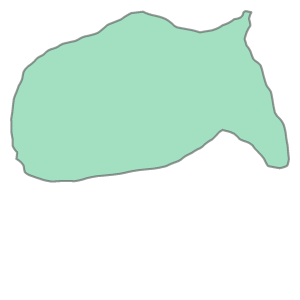

In [11]:
maskPolygon

In [12]:
# rgb color list
colorList = [[191, 214, 230], [107, 174, 216], [33, 114, 180], [239, 243, 255]] # the third color is the darkest one
# colorList = [[191, 214, 230], [107, 174, 216], [33, 114, 180], [239, 243, 255]]

In [13]:
def bgr2rgb(value):
    return value[2],value[0],value[1]
def valueEqualColor(value,color):
    colorR, colorG, colorB = color[0], color[1], color[2]
    valueR, valueG, valueB = value[0], value[1], value[2]
    if abs(colorR - valueR) > 10 or abs(colorB - valueB) > 10 or abs(colorG - valueG) > 10:
        return False
    else:
        return True

In [14]:
def rgb2Grey(dominantColor):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    dominantColorGrey = int(np.dot(dominantColor, rgb_weights))
    return dominantColorGrey

In [15]:
# traverse the whole image
colorGrey0 = rgb2Grey(colorList[0])
colorGrey1 = rgb2Grey(colorList[1])
colorGrey2 = rgb2Grey(colorList[2])
colorGrey3 = rgb2Grey(colorList[3])

In [16]:
pixelCoordList0, pixelCoordList1, pixelCoordList2, pixelCoordList3 = [],[],[],[]
for i in range(height):
    if i % 100 == 0:
        print(i)
    for j in range(mask.shape[1]):
        # test x,y axis
#         if i != 148 or j != 257:
#             continue
        point = Point(j,i)
        
#         if bboxMap.contains(point) and maskPolygon.contains(point):
        if mask[i,j] == True:
#             print('yes!')
            value =  imageGray[i,j]
#             print(value)
            b, g, r = image[i,j]
#             value_rgb = value
#             print(value_rgb)
            if not (abs(b - g) < 10 and abs(b-r) < 10 and abs(g - r)<10):
                if abs(value - colorGrey0) <= 10:
#                     print('0: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList0.append((j,i))  
                elif abs(value - colorGrey1) <= 10:
#                     print('1: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList1.append((j,i))  
                elif abs(value - colorGrey2) <= 10:
#                     print('0: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList2.append((j,i))  
                elif abs(value - colorGrey3) <= 10:
#                     print('0: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList3.append((j,i))  

0
100


C:\Users\jiali\anaconda3\envs\imageProcess\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars


200
300
400
500
600
700
800
900


In [17]:
pixelCoordList0_sample = sample(pixelCoordList0,int(len(pixelCoordList0)/100))
pixelCoordList1_sample = sample(pixelCoordList1,int(len(pixelCoordList1)/100))
pixelCoordList2_sample = sample(pixelCoordList2,int(len(pixelCoordList2)/100))
pixelCoordList3_sample = sample(pixelCoordList3,int(len(pixelCoordList3)/100))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

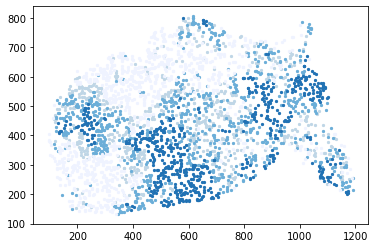

In [18]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in pixelCoordList0_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList0_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[0])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList1_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList1_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[1])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList2_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList2_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[2])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList3_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList3_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[3])/255.0)
plt.show()

In [19]:
def moransi(z, w):
    """
    Input
      z: list of values
      w: weight matrix
    Output
      I: Moran's I measure
    """
    n = len(z)
    mean = float(sum(z))/n
    S0 = 0
    d = 0
    var = 0
    for i in range(n):
        var += (z[i]-mean)**2
        for j in range(i):
            if w[i][j]:
                S0 += w[i][j]
                d += w[i][j] * (z[i]-mean) * (z[j]-mean)
    I = n*d/S0/var
    return I

In [20]:
len0 = len(pixelCoordList0_sample)
len1 = len(pixelCoordList1_sample)
len2 = len(pixelCoordList2_sample)
len3 = len(pixelCoordList3_sample)

In [21]:
zList0 = [colorGrey0 for i in range(len0)]
zList1 = [colorGrey1 for i in range(len1)]
zList2 = [colorGrey2 for i in range(len2)]
zList3 = [colorGrey3 for i in range(len3)]

In [22]:
# attribute list and coordinate list
zList = zList0 + zList1 + zList2 + zList3
pixelCoordList_sample = pixelCoordList0_sample + pixelCoordList1_sample + pixelCoordList2_sample + pixelCoordList3_sample

In [23]:
wMatrix = np.zeros(shape=(len(zList), len(zList)))

In [24]:
import math

In [25]:
def distance(coord1, coord2):
    x1, y1 = coord1[0], coord1[1]
    x2, y2 = coord2[0], coord2[1]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist

In [26]:
# 1/(distance(pixelCoordList_sample[i], pixelCoordList_sample[j]) + 0.0000001)
def calculateKNeighWeight(i, coordList, k = 6): 
    # i is the currently target, k includes the point itself
    # k nearest neighborhood, only consider the k nearest neighbors
    # based on distance to calcuate weight, and normalize weight
    distList = []
    for j in range(len(coordList)):
        dist = distance(coordList[i], coordList[j])
        distList.append(dist)
    
    neighIndice = sorted(range(len(distList)), key = lambda sub: distList[sub])[:k]
    distNeigh = [distList[ind] for ind in neighIndice]

    neighIndice = neighIndice[1:]
    distNeigh = distNeigh[1:]
    wNeigh = [1/(distNeigh[j]+ 0.00000001) for j in range(len(distNeigh))]
    
    # normalize weights
    wNeighNorm = (np.asarray(wNeigh)/sum(wNeigh)).tolist()
    
    # put weights together
    wList = [0 for j in range(len(coordList))]
    for ind, j in enumerate(neighIndice):
        wList[j] = wNeighNorm[ind]
        
    return wList

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [29]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList0_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans0 = KMeans(n_clusters = numClusters).fit(x)
kmeans0.cluster_centers_

[0.4493424864989012, 0.46790177632447005, 0.4509180116734347, 0.48590667010664224, 0.48799793305149824, 0.4967778410225151, 0.4904307486046021, 0.4738648572329656, 0.4619371752395012, 0.46205222173393506, 0.4526605562574989, 0.4509348429830434, 0.4489071852147081, 0.4569560625164659, 0.45189839994809017, 0.4539710155184183, 0.4495973169400036, 0.4487535854755867, 0.4394392286546212, 0.4368748461128845, 0.4356162174605048, 0.4652857886964004, 0.449029627078781, 0.4406839015574207, 0.4389806927279485, 0.4365037300224772, 0.44943329163980994, 0.4459621579654859, 0.44642615223377224, 0.4435626606084773, 0.4467780651305542, 0.44962594935586664, 0.4384707803594525, 0.4439908162063436, 0.4510544793647417, 0.46522767857278147, 0.4499156557668166, 0.4474488553848825, 0.4584264600814776, 0.4673009159942524, 0.4526943905395194, 0.4536432863941226, 0.4353523720107798, 0.45296891741806966, 0.4563208595959935, 0.456028131092674, 0.44796411877513065, 0.4524820201559063, 0.45842524379586197, 0.4550290

array([[ 710.45398773,  419.5398773 ],
       [ 224.888     ,  491.152     ],
       [ 613.425     ,  732.975     ],
       [ 898.80769231,  657.17307692],
       [ 381.26      ,  309.27      ],
       [1050.92957746,  375.38028169],
       [ 511.71830986,  520.50704225]])

In [30]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList1_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans1 = KMeans(n_clusters = numClusters).fit(x)
kmeans1.cluster_centers_

[0.4178260207484693, 0.4332590261785094, 0.44475227410350043, 0.46152983570193523, 0.48637192984846983, 0.48914638943178007, 0.45989402950225167, 0.45971658499792745, 0.45984788715813585, 0.4600340647925355, 0.44255259709460043, 0.4551174312651778, 0.4518395741647351, 0.4455586052119214, 0.43060128794499314, 0.43142102865428106, 0.4530594549192104, 0.42987405723435146, 0.4356255297122762, 0.4370577203330653, 0.4389162922894215, 0.43076122700032243, 0.4452872522667723, 0.4337308920451992, 0.44410910123586467, 0.4403981821281054, 0.4460077112750943, 0.442523720961424, 0.44818590376627465, 0.43731683819755324, 0.4433487879486959, 0.44242486388830465, 0.4533369818792479, 0.4579841176049983, 0.4470082002523618, 0.4464928478527504, 0.45408294401631705, 0.45548534429345316, 0.460455750466058, 0.45454069998468216, 0.4562870424172101, 0.4521344783230657, 0.4581438092657213, 0.4527521685632872, 0.4554841444930594, 0.45857687414840353, 0.45395204799892963, 0.45600435772839976, 0.46048766943240715

array([[1077.92771084,  358.86746988],
       [ 404.04301075,  213.66666667],
       [ 578.29545455,  487.76515152],
       [ 254.84895833,  443.31770833],
       [ 908.97272727,  609.75454545],
       [ 745.98709677,  344.40645161],
       [ 642.17307692,  748.75      ]])

In [31]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList2_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans2 = KMeans(n_clusters = numClusters).fit(x)
kmeans2.cluster_centers_

[0.5610275290017964, 0.5303174609824237, 0.4835647858916129, 0.48621857713876504, 0.5062002387121635, 0.5208735225272864, 0.49570268614176344, 0.47261323971441765, 0.4718914808664986, 0.4707042452707709, 0.4729334738340947, 0.441717964680285, 0.45924155384785564, 0.45425886301414686, 0.4569275717536306, 0.44737319640222817, 0.42199337220359273, 0.4538869267299516, 0.4356392349298406, 0.45309292022686426, 0.4129569430698206, 0.4375180669434538, 0.4379168683459664, 0.4282072257916156, 0.43632698407707204, 0.4264920378105951, 0.4311734540628831, 0.4325519550235675, 0.4340417872608539, 0.4286586421771844, 0.4323309404180946, 0.4337982768925112, 0.4352549081363109, 0.43876593103406925, 0.4369524094871255, 0.44189041341153595, 0.44335355843380747, 0.43919429905731305, 0.4341754272740794, 0.44423917436344124, 0.43797532065223954, 0.4406536605711655, 0.4324833025335918, 0.4410936178075646, 0.44262173851930925, 0.45055145163201926, 0.43013303363099753, 0.43502704780191115, 0.4522161502771095, 0

array([[494.74111675, 319.1928934 ],
       [946.7854251 , 473.49392713]])

In [32]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList3_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans3 = KMeans(n_clusters = numClusters).fit(x)
kmeans3.cluster_centers_

[0.5374196289816808, 0.5368234860807612, 0.4857660960552698, 0.41568994989621794, 0.419222806468299, 0.40370251015162145, 0.41696868276276394, 0.41840583625869243, 0.4053985003494712, 0.405730087117229, 0.3992617627844133, 0.3891994925503305, 0.3857385213269179, 0.40294471375429736, 0.39054116881109574, 0.3723364751393754, 0.3921009593450529, 0.39833943869911964, 0.39411303178915036, 0.39858954537481867, 0.39207807015326973, 0.39291121176810007, 0.3955569487322132, 0.39559431483009355, 0.39846438161419173, 0.398852813783204, 0.4028378366487626, 0.3968019887614723, 0.39419418446583826, 0.40469960706595137, 0.3956428111614866, 0.4015466660016736, 0.40122706009176856, 0.4124777846982365, 0.4115316792597247, 0.4019910288836647, 0.40837264975891996, 0.4035802453330756, 0.4066213390677667, 0.4104468534469395, 0.40838059389788167, 0.40791526792291427, 0.4191705069342287, 0.4194644396306576, 0.41311832111811625, 0.405132840428109, 0.42381119694961394, 0.4177102251963652, 0.4180545224841873, 0.

array([[282.37204301, 367.94623656],
       [617.10859729, 601.85746606]])

In [33]:
kmeans3.cluster_centers_.shape

(2, 2)

###  based on the optimal clustering results to conduct concentration analysis

In [34]:
zCenters0 = [colorGrey0 for i in range(kmeans0.cluster_centers_.shape[0])]
zCenters1 = [colorGrey1 for i in range(kmeans1.cluster_centers_.shape[0])]
zCenters2 = [colorGrey2 for i in range(kmeans2.cluster_centers_.shape[0])]
zCenters3 = [colorGrey3 for i in range(kmeans3.cluster_centers_.shape[0])]

In [35]:
coordCenters0 = kmeans0.cluster_centers_.tolist()
coordCenters1 = kmeans1.cluster_centers_.tolist()
coordCenters2 = kmeans2.cluster_centers_.tolist()
coordCenters3 = kmeans3.cluster_centers_.tolist()

In [36]:
zCenters = zCenters0 + zCenters1 + zCenters2 + zCenters3
coordCenters = coordCenters0 + coordCenters1 + coordCenters2 + coordCenters3

In [37]:
wMatrix = np.zeros(shape=(len(zCenters), len(zCenters)))

In [38]:
for i in range(len(zCenters)):
    wMatrix[i] = calculateKNeighWeight(i, coordCenters)
    print(wMatrix[i])

[0.         0.         0.         0.         0.         0.
 0.13877081 0.         0.         0.20798669 0.         0.
 0.37219369 0.         0.13002278 0.         0.         0.15102603]
[0.         0.         0.         0.         0.11634145 0.
 0.09678462 0.         0.         0.         0.49440879 0.
 0.         0.         0.08720951 0.         0.20525564 0.        ]
[0.         0.         0.         0.06802117 0.         0.
 0.08526686 0.         0.         0.08108226 0.         0.
 0.         0.61250567 0.         0.         0.         0.15312403]
[0.         0.         0.09296843 0.         0.         0.
 0.         0.         0.         0.         0.         0.56606007
 0.         0.10074546 0.         0.14460227 0.         0.09562377]
[0.         0.11193166 0.         0.         0.         0.
 0.         0.         0.27317752 0.         0.14571421 0.
 0.         0.         0.23568659 0.         0.23349002 0.        ]
[0.         0.         0.         0.06422524 0.         0.
 0.

In [39]:
w = wMatrix.tolist()
moransi(zCenters, w)

-0.15860752581348642

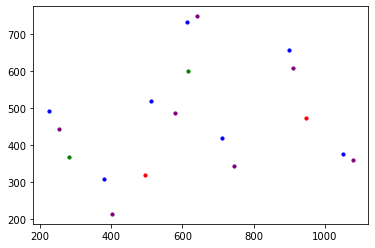

In [40]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in coordCenters0]
yList = [pixelCoord[1] for pixelCoord in coordCenters0]
ax.scatter(xList, yList, s = 10,c = 'blue')

xList = [pixelCoord[0] for pixelCoord in coordCenters1]
yList = [pixelCoord[1] for pixelCoord in coordCenters1]
ax.scatter(xList, yList, s = 10,c = 'purple')

# only focus on the category with largest value
xList = [pixelCoord[0] for pixelCoord in coordCenters2]
yList = [pixelCoord[1] for pixelCoord in coordCenters2]
ax.scatter(xList, yList, s = 10,c = 'red')

xList = [pixelCoord[0] for pixelCoord in coordCenters3]
yList = [pixelCoord[1] for pixelCoord in coordCenters3]
ax.scatter(xList, yList, s = 10,c = 'green')
plt.show()

### try to use the random lines to get number of clusters

#### first use a horizontal line as a prototype

In [41]:
pixelCoordList_sample[0]

(1061, 473)

In [42]:
xList = [pixelCoord[0] for pixelCoord in pixelCoordList_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList_sample]
xMin, xMax = min(xList), max(xList)
yMin, yMax = min(yList), max(yList)
yMid = int((yMin + yMax) / 2)
xMin, xMax, yMin, yMax, yMid

(96, 1191, 133, 806, 469)

In [43]:
def calculateKNeigh(targetCoord, coordList, k = 6): 
    # targetCoord is the coordinate of current point
    # k nearest neighborhood, only consider the k nearest neighbors
    # CoordList is the set of coordinates to compare
    distList = []
    for j in range(len(coordList)):
        dist = distance(targetCoord, coordList[j])
        distList.append(dist)
    
    neighIndice = sorted(range(len(distList)), key = lambda sub: distList[sub])[:k]
#     [distList[ind] for ind in neighIndice]

    return neighIndice

In [44]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [45]:
def mostCommonListHLine(y,xMin, xMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for x in range(xMin, xMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [46]:
def mostCommonListVLine(x,yMin, yMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for y in range(yMin, yMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [47]:
mostCommonListLines = []
for y in range(yMin, yMax + 1, int((yMax + 1 - yMin) / 10)):
    print(y)
    mostCommonList = mostCommonListHLine(y, xMin, xMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

133
200
267
334
401
468
535
602
669
736
803


In [48]:
for x in range(xMin, xMax + 1, int((xMax + 1 - xMin) / 10)):
    print(x)
    mostCommonList = mostCommonListVLine(x, yMin, yMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

96
205
314
423
532
641
750
859
968
1077
1186


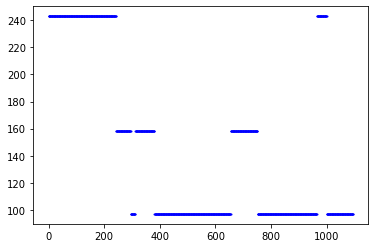

In [49]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [i for i in range(len(mostCommonListLines[0]))]
yList = mostCommonListLines[0]
ax.scatter(xList, yList, s = 1,c = 'blue')

In [50]:
def countSegmentationFun(mostCommonList):
    countSegmentation = 1
    currentValue = mostCommonList[0]
    countDifferentTemp = 0
    for i in range(len(mostCommonList)):
        if mostCommonList[i] ==  currentValue:
            countDifferentTemp = 0
            continue
        else:
            countDifferentTemp += 1
            if countDifferentTemp > 20:
                currentValue = mostCommonList[i]
                countSegmentation += 1
    return countSegmentation

In [51]:
countSegmentationList = []
for mostCommonList in mostCommonListLines:
    countSegmentation = countSegmentationFun(mostCommonList)
    countSegmentationList.append(countSegmentation)
countSegmentationList

[7, 8, 11, 15, 21, 15, 10, 12, 8, 7, 8, 4, 6, 4, 6, 8, 9, 9, 9, 8, 8, 9]

In [52]:
countSegmentation = max(countSegmentationList)
totalNumCluster = countSegmentation**2
numClusterEach = math.ceil(totalNumCluster / 4)
print(numClusterEach)
numCluster0, numCluster1, numCluster2, numCluster3 = numClusterEach,numClusterEach,numClusterEach,numClusterEach

111


In [53]:
kmeans0 = KMeans(n_clusters = numCluster0).fit(pixelCoordList0_sample)
kmeans1 = KMeans(n_clusters = numCluster1).fit(pixelCoordList1_sample)
kmeans2 = KMeans(n_clusters = numCluster2).fit(pixelCoordList2_sample)
kmeans3 = KMeans(n_clusters = numCluster3).fit(pixelCoordList3_sample)


In [54]:
zCenters0 = [colorGrey0 for i in range(kmeans0.cluster_centers_.shape[0])]
zCenters1 = [colorGrey1 for i in range(kmeans1.cluster_centers_.shape[0])]
zCenters2 = [colorGrey2 for i in range(kmeans2.cluster_centers_.shape[0])]
zCenters3 = [colorGrey3 for i in range(kmeans3.cluster_centers_.shape[0])]

In [55]:
coordCenters0 = kmeans0.cluster_centers_.tolist()
coordCenters1 = kmeans1.cluster_centers_.tolist()
coordCenters2 = kmeans2.cluster_centers_.tolist()
coordCenters3 = kmeans3.cluster_centers_.tolist()

In [56]:
zCenters = zCenters0 + zCenters1 + zCenters2 + zCenters3
coordCenters = coordCenters0 + coordCenters1 + coordCenters2 + coordCenters3

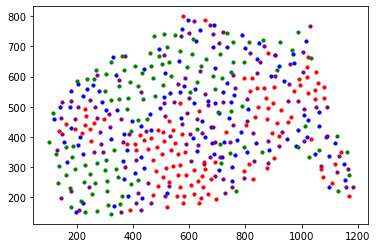

In [57]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in coordCenters0]
yList = [pixelCoord[1] for pixelCoord in coordCenters0]
ax.scatter(xList, yList, s = 10,c = 'blue')

xList = [pixelCoord[0] for pixelCoord in coordCenters1]
yList = [pixelCoord[1] for pixelCoord in coordCenters1]
ax.scatter(xList, yList, s = 10,c = 'purple')

# only focus on the category with largest value
xList = [pixelCoord[0] for pixelCoord in coordCenters2]
yList = [pixelCoord[1] for pixelCoord in coordCenters2]
ax.scatter(xList, yList, s = 10,c = 'red')

xList = [pixelCoord[0] for pixelCoord in coordCenters3]
yList = [pixelCoord[1] for pixelCoord in coordCenters3]
ax.scatter(xList, yList, s = 10,c = 'green')
plt.show()

In [58]:
import math
from sklearn.neighbors import KDTree

In [59]:
classHighestValues = coordCenters2 # the third color is with the largest value
X = np.array([[coord[0],coord[1]] for coord in classHighestValues])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
queryResults = kdt.query(X, k=len(classHighestValues), return_distance=True)
distanceArray = queryResults[0]
distanceArray

array([[   0.        ,   20.32953516,   36.38804749, ...,  757.90585827,
         787.37885558,  812.77601192],
       [   0.        ,   24.93829119,   26.71581355, ...,  599.10019689,
         600.22859591,  635.00994734],
       [   0.        ,   33.84810843,   34.01184434, ...,  965.58335851,
         982.68080044, 1034.35117881],
       ...,
       [   0.        ,   21.28673296,   32.61145419, ...,  869.83674474,
         885.63695299,  940.12818644],
       [   0.        ,   31.20470413,   32.96509564, ...,  612.75411962,
         630.8900679 ,  682.80607707],
       [   0.        ,   35.70762835,   37.80477997, ...,  547.17557613,
         549.89746519,  563.68453057]])

In [60]:
import statistics

In [67]:
distanceList = distanceArray.tolist()
distanceList = [statistics.median(distances) for distances in distanceList]
distanceList

[369.8796459660899,
 287.20084036102963,
 516.3642394451592,
 462.98406108237305,
 541.6726574027692,
 254.0215925311987,
 295.04747828857046,
 479.11364924085484,
 325.35924760178557,
 287.1781870391815,
 331.8695677521517,
 306.50279076021747,
 439.68454885292476,
 429.7854519667018,
 536.7853797166526,
 275.3306377238909,
 258.702706359593,
 369.14083923919185,
 308.88214277455404,
 323.70116534304356,
 269.6778170335855,
 274.3239164037855,
 258.88004471380253,
 244.791358155834,
 532.5862280211326,
 389.40316125509923,
 238.97444365919597,
 289.1448524165912,
 293.1071571210016,
 427.29929141579953,
 346.14233183603665,
 471.22356593550205,
 308.3768635938825,
 477.8531910767387,
 302.76018562552116,
 274.98650535071715,
 350.7466030092061,
 454.2531817444981,
 519.3590447218003,
 280.01200889881676,
 263.9353369421701,
 280.4200654821263,
 254.31046151432503,
 535.7095243174648,
 338.431224737835,
 492.10572034878845,
 477.7340054884099,
 306.4134132947492,
 266.47489184666887,
 

In [68]:
aveMedianDistanceCenters = sum(distanceList)/len(distanceList)
aveMedianDistanceCenters

352.8507118140099

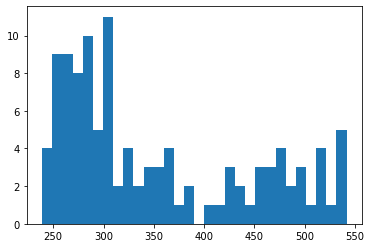

In [62]:
plt.hist(distanceList, 30)
plt.show()

In [63]:
import alphashape

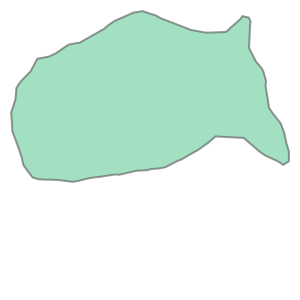

In [64]:
alpha_shape = alphashape.alphashape(pixelCoordList_sample, 0.01) # convex hull
alpha_shape

In [65]:
xList = [pixelCoord[0] for pixelCoord in pixelCoordList_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList_sample]
xMin, xMax = min(xList), max(xList)
yMin, yMax = min(yList), max(yList)
yMid = int((yMin + yMax) / 2)
xMin, xMax, yMin, yMax, yMid

(96, 1191, 133, 806, 469)

In [ ]:
len(distanceList)

In [69]:
import random
randomPointListMonteCarlo = []

numMonteCarlo = 10000
numClusterCenters = len(distanceList)
for i in range(numMonteCarlo):
    randomPointList = []
    while len(randomPointList) < numClusterCenters:
        x = random.randint(xMin,xMax )
        y = random.randint(yMin,yMax )
        point = Point(x,y)
        if alpha_shape.contains(point):
            randomPointList.append(point)
    randomPointListMonteCarlo.append(randomPointList)

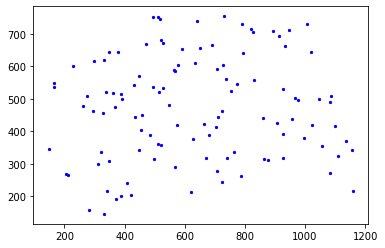

In [70]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord.x for pixelCoord in randomPointList]
yList = [pixelCoord.y for pixelCoord in randomPointList]
ax.scatter(xList, yList, s = 5,c = 'blue')

plt.show()

In [91]:
import statistics

In [71]:
aveMedianDistanceMonteCarlo = []
for randomPointList in randomPointListMonteCarlo:
    X = np.array([[pixelCoord.x,pixelCoord.y] for pixelCoord in randomPointList])
    kdt = KDTree(X, leaf_size=30, metric='euclidean')
    queryResultsAllRandom = kdt.query(X, k=len(distanceList), return_distance=True)
    distanceArrayAllRandom = queryResultsAllRandom[0]
    distanceListAllRandom = distanceArrayAllRandom.tolist()
    distanceListAllRandom = [statistics.median(distanceAllRandom) for distanceAllRandom in distanceListAllRandom]
    aveMedianDistanceRandom = sum(distanceListAllRandom)/len(distanceListAllRandom)
    aveMedianDistanceMonteCarlo.append(aveMedianDistanceRandom)

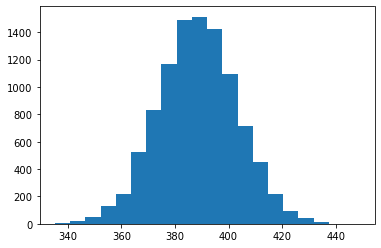

In [72]:
plt.hist(aveMedianDistanceMonteCarlo, 20)
plt.show()

In [73]:
aveMedianDistMontArray = np.asarray(aveMedianDistanceMonteCarlo)
aveMedDistPercentage25 = np.percentile(aveMedianDistMontArray, 2.5)
aveMedDistPercentage25

360.1624259329431

In [74]:
if aveMedianDistanceCenters < aveMedDistPercentage25:
    print('concentrated!')
else:
    print('not concentrated...')

concentrated!


In [94]:
from scipy.stats import ranksums
randomSampleArray = np.asarray(distanceListAllRandom)
mapSampleArray = np.asarray(distanceList)
ranksums(mapSampleArray, randomSampleArray)

RanksumsResult(statistic=-3.331321819793191, pvalue=0.0008643461400874329)

In [95]:
ranksums(mapSampleArray, randomSampleArray,alternative = 'less')

RanksumsResult(statistic=-3.331321819793191, pvalue=0.00043217307004371643)

In [96]:
ranksums(mapSampleArray, randomSampleArray,alternative = 'greater')

RanksumsResult(statistic=-3.331321819793191, pvalue=0.9995678269299563)